# Eclipsing Binary Star Populations: Data Generation and Analysis
Tess Kleanthous, Nick Dahlen, and Mason Sibley

---


# Part 1 - Introduction and Initialization

## 1.1 - What are Eclipsing Binary Stars?
Today we will be generating a population of binary star systems in order to characterize them by their celestial parameters and orbital geometry with a focus being placed on eclipsing binaries. An eclipsing binary star system is a pair of stars that orbit eachother in such a way that one star may move in front of the other and block our view of the star. We are going to be focusing on primary and secondary eclipses. The primary eclipse being when the less massive star in the binary blocks the more massive star. The secondary eclipse being the opposite. While there are full and partial eclipses, we are considering partial eclipses as an eclipse for the sake of this analysis.

## 1.2 - What tools will we be using?

We will be using the following tools to do an in-depth analysis:

**Probability Density Function**: a function that produces the likelihood of a variable lying between a specific range of values

**Cumulative Distribution Function**: a function that returns the probability that random variable X is less than or equal to x

**Inverse Transform Sampling**: a method for generating random numbers from any probability distribution by using its inverse cumulative distribution.

## 1.3 - Preparation and Initialization

We'll begin by setting up the constants, libraries, and data structure we'll be using later in the program.

In [67]:
#Import useful libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import pandas as pd
from scipy.stats import norm

# A few constants
au2m = 1.49598e11 ; # Conversion factor from au to meters
rSun_m = 6.9634e8; # Radius of the Sun, in metres
mSun_kg = 1.988416e30 #In kilograms

# Part 2 - Generating Our Distributions

## 2.1 - The Initial Mass Function
Our first step to modeling a binary star population will be finding the dimensions of our primary star. We will use the Salpeter model to find a probability density function:

$$
\xi(m) \Delta m = \xi_0 \left(\frac{m}{M_{\odot}}\right)^{-2.35} \left(\frac{\Delta m}{M_{\odot}}\right)
$$

This function describes the initial masses of a population of stars during  formation where:

$$\xi_0 \text{: constant relating to the local stellar density (normalization factor)}$$
$$\frac{m}{M_{\odot}} \text{ : mass of star} $$
$$ \frac{\Delta m}{M_{\odot}} \text{ : inclusion of stars given in a mass interval}$$

Now that everything is defined, we can continue with the derivation of the normalization constant. For the sake of simplicity:
$$
{m_{\odot}} = \frac{m}{M_{\odot}}
$$

The integral for the normalization constant of the Salpeter IMF is given by:

$$
\int_{m_{\odot\text{min}}}^{m_{\odot\text{max}}} \xi_0 m_{\odot}^{-2.35} \, dm_{\odot} = 1
$$

Performing the integration:

$$
\xi_0 \left[ \frac{m_\odot^{-1.35}}{-1.35} \right]_{m_{\odot\text{min}}}^{m_{\odot\text{max}}} = 1
$$

Evaluating the limits:

$$
\xi_0 \left( \frac{m_{\odot\text{max}}^{-1.35} - m_{\odot\text{min}}^{-1.35}}{-1.35} \right) = 1
$$

Solving:

$$
\xi_0 = \frac{1.35}{m_{\odot\text{min}}^{-1.35} - m_{\odot\text{max}}^{-1.35}}.
$$

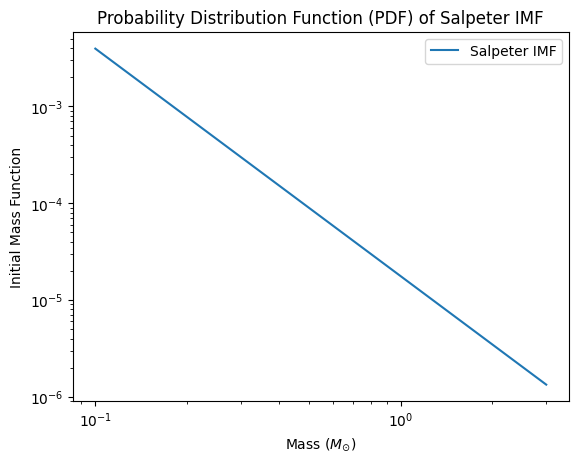

In [68]:
# Define mass range
m_min, m_max = 0.1, 3  # Solar masses
num_points = 10000
mass = np.linspace(m_min, m_max, num_points)  # Mass grid

# Compute normalization factor
N = 1.35 / (m_min**(-1.35) - m_max**(-1.35))

# Compute probability density function (PDF) using Salpeter IMF
delta_m = np.gradient(mass)  # Compute mass bin widths
pdfStellarMass = N * (mass**(-2.35)) * (delta_m / 1.0)

# Plot
plt.plot(mass, pdfStellarMass, label="Salpeter IMF")
plt.title("Probability Distribution Function (PDF) of Salpeter IMF")
plt.xlabel("Mass ($M_{\odot}$)")
plt.ylabel("Initial Mass Function")
plt.yscale("log")  # Log scale for better visualization
plt.xscale("log")
plt.legend()
plt.show()


## 2.2 - Generating the CDF from the PDF

This gives us a probability density function (pdf); now we will transform it into a cumulative distribution function (cdf) using the inverse transform. From there, we will have a graph spanning from 0 to 1 on the y-axis, allowing us to use randomly generated numbers in that range to sample their corresponding x values. Since the slope of the cdf corresponds to the area of the pdf, our sampled values should be proportional to the salpeter model's distribution.

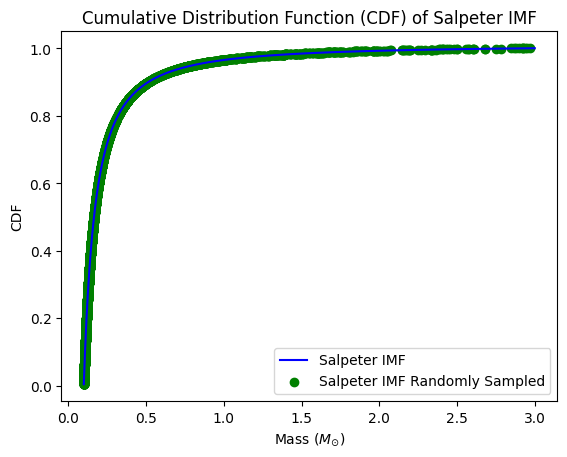

In [69]:
# Function to convert PDF to CDF
def pdf2cdf(pdf, x):
    delta_x = np.gradient(x) # Compute bin widths
    area = pdf * delta_x # Element-wise multiplication
    cdf = np.cumsum(area) # Cumulative sum to get CDF
    cdf /= cdf[-1]  # Normalize CDF

    return cdf

# Optimized Sampling Function
def sampling(numberSamples, cdf, x):
    randomNumbers = np.random.rand(numberSamples) # Generate random numbers
    indices = np.searchsorted(cdf, randomNumbers) #Binary search in CDF
    sampledx = x[indices] # Map to x-values
    sampledy = cdf[indices]

    return sampledx, sampledy

cdfStellarMass = pdf2cdf(pdfStellarMass, mass)

num_samples = 10000
primaryMassArray, cdfSampled = sampling(num_samples, cdfStellarMass, mass)

# Plot the CDF
plt.plot(mass, cdfStellarMass, c = 'b', label="Salpeter IMF")
plt.scatter(primaryMassArray, cdfSampled, color = 'g', label="Salpeter IMF Randomly Sampled")
plt.xlabel("Mass ($M_{\odot}$)")
plt.ylabel("CDF")
plt.title("Cumulative Distribution Function (CDF) of Salpeter IMF")
plt.legend()
plt.show()


## 2.3 - Mass Ratio, Secondary Masses, and Stellar Radii
 Now that we have the primary masses, we can apply a uniform distribution of mass ratios to them to find the secondary stars' masses. Since the primary star must be more massive than the secondary, but not so much more massive that the secondary does not qualify as a star, we will use a uniform distribution of ratios from 0.1-1, then reroll until we get a sufficiently massive resulting star. We then pass both the primary and secondary masses into a function to find their corresponding radii.

In [70]:
#Create a list for our mass ratios and our secondary masses
secondaryMassList = []
massRatioArray = []

#Use a random mass ratio between 0.1 and 1 to generate secondary stars. Reroll to ensure both stars are massive enough to achieve fusion
lowerBound = 0.08 #In solar masses
for x in range(len(primaryMassArray)):
  randomFactor = 0
  #Keep rerolling until we have a secondary mass that both exceeds the minimum stellar mass and is at least 10% the size of the primary
  while randomFactor*primaryMassArray[x] < lowerBound:
    randomFactor = np.random.rand()
    while randomFactor < 0.1:
      randomFactor = np.random.rand()

  massRatioArray.append(randomFactor)
  secondaryMassList.append(randomFactor*primaryMassArray[x])

#Quick sanity check to make sure the secondary mass list are actually within the necessary ranges:
for x in range(len(secondaryMassList)):
  if secondaryMassList[x] < 0.08 or secondaryMassList[x] < primaryMassArray[x]*0.1:
    print("We have a problem")


#Convert the lists to an array, then use it to calculate our secondary masses
massRatioArray = np.array(massRatioArray)
secondaryMassArray = np.array(secondaryMassList)

#Now find the radii for each primary and secondary star, have to add in chi
chiPrim = np.where(primaryMassArray > 1, 0.53, 0.8)
chiSec = np.where(secondaryMassArray > 1, 0.53, 0.8)


primaryRadiusArray = ((primaryMassArray)**chiPrim)
secondaryRadiusArray = ((secondaryMassArray)**chiSec)

## 2.4 - Sanity check 1
We can do a quick sanity check to make sure all of our stars are actually large enough to undergo fusion - this is estimated to require at lest 75 times the mass of Jupiter or 0.08 solar masses.

In [71]:
wrongPrimaries = 0
wrongSecondaries = 0

minStarMass = 0.08#*solarMass
for i in range(len(primaryMassArray)):
  if primaryMassArray[i] < minStarMass:
    wrongPrimaries += 1

for i in range(len(secondaryMassArray)):
    if secondaryMassArray[i] < minStarMass:
      wrongSecondaries += 1

if wrongPrimaries + wrongSecondaries == 0:
  print("Looks like we're good!")
else:
  print("Looks like we have some issues")
  # Create a mask to identify indices where the secondary mass is below the minimum star mass
  valid_indices_secondary = [i for i in range(len(secondaryMassArray)) if secondaryMassArray[i] >= minStarMass]

  # Filter mass ratio using the same valid indices
  massRatioArray = [massRatioArray[i] for i in valid_indices_secondary]

  # Filter primary and secondary masses using the valid indices
  primaryMassArray = [primaryMassArray[i] for i in valid_indices_secondary]
  secondaryMassArray = [secondaryMassArray[i] for i in valid_indices_secondary]

  # Filter secondary radii using the same valid indices
  primaryRadiusArray = [primaryRadiusArray[i] for i in valid_indices_secondary]
  secondaryRadiusArray = [secondaryRadiusArray[i] for i in valid_indices_secondary]

  # Check how many values were removed
  print("Number of primaries below minimum removed:", wrongPrimaries)
  print("Number of secondaries below minimum removed:", wrongSecondaries)

Looks like we're good!


## 2.5 - Graphing Mass and Radius for the Binary Systems

Let's see what our primary and secondary mass distributions look like on a graph!

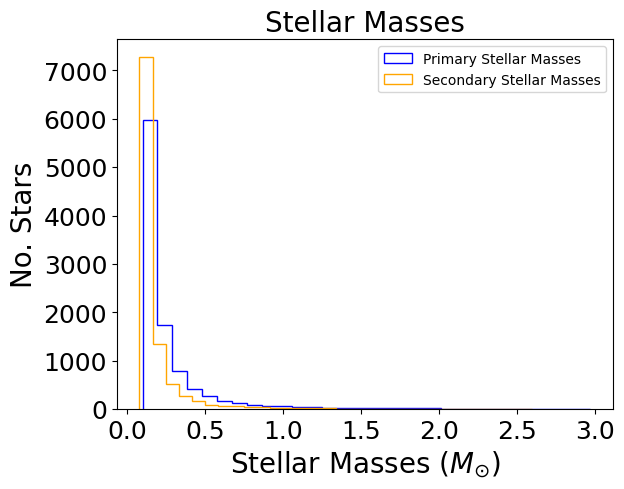

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(primaryMassArray,bins=30, histtype = "step", color = 'blue', label='Primary Stellar Masses')
ax.hist(secondaryMassArray,bins=30, histtype = "step", color = 'orange', label='Secondary Stellar Masses')
ax.set_title("Stellar Masses", fontsize=20)
ax.set_xlabel('Stellar Masses ($M_{\odot}$)', fontsize=20)
ax.set_ylabel('No. Stars',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
plt.show()

Let's also take a look at the radii!

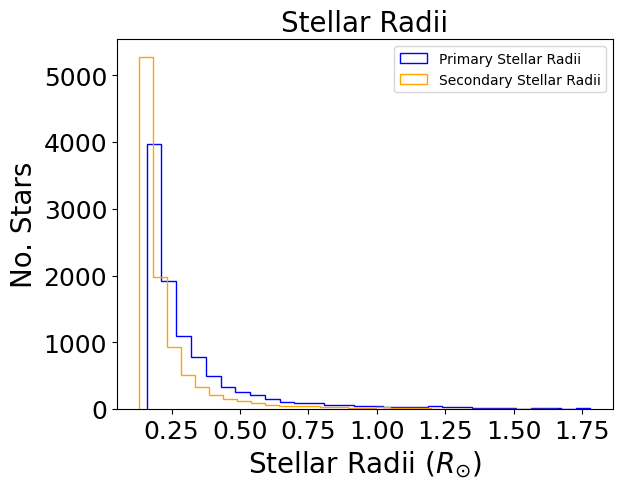

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(primaryRadiusArray,bins=30, histtype = "step", color = 'blue', label='Primary Stellar Radii')
ax.hist(secondaryRadiusArray,bins=30,histtype = "step", color = 'orange', label='Secondary Stellar Radii')
ax.set_title("Stellar Radii", fontsize=20)
ax.set_xlabel('Stellar Radii ($R_{\odot}$)', fontsize=20)
ax.set_ylabel('No. Stars',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
plt.show()

## 2.6 - Generating the Period Distribution

The period distribution is a log-normal distribution with a mean of 5.03 and standard deviation of 2.28. While a normal distribution peaks at its mode, mean, and median, a log normal distribution is skewed. When plotted on a linear scale of period, the log normal distribution will peak at the mode while the median and mean will have been shifted to the right of the mode (the order would be mode < median < mean from left to right). However, when plotting logP the distribution will appear as a normal distribution with a peak at, in this case, 5.03.

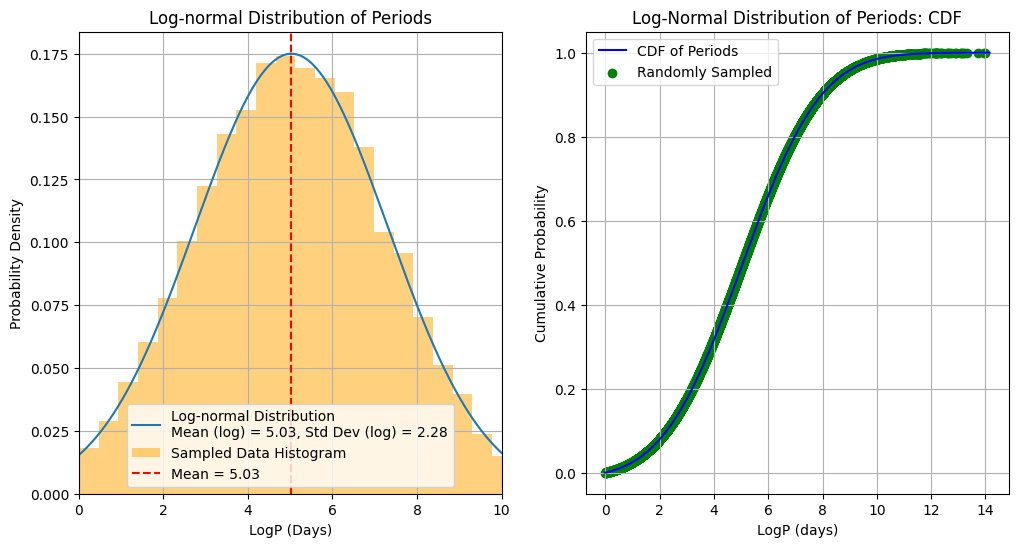

In [74]:
# Define parameters
mu_logP = 5.03
sigma_logP = 2.28

# Generate logP values (in log-space)
logP = np.linspace(mu_logP - 4*sigma_logP, mu_logP + 4*sigma_logP, 100000)

#get rid of negatives
logP = logP[logP > 0]

# Compute the normal PDF manually
pdf_logP = (1 / (sigma_logP * np.sqrt(2 * np.pi))) * np.exp(-((logP - mu_logP) ** 2) / (2 * sigma_logP ** 2))

# Generate CDF
Periodscdf = pdf2cdf(pdf_logP, logP)

# Generate samples using the custom PDF
num_samples = len(secondaryMassArray) * 2
sampledPeriods, sampledcdf = sampling(num_samples, Periodscdf, logP)


# Plot the PDF and CDF
plt.figure(figsize=(12, 6))

# Plotting the log-normal distribution
plt.subplot(1, 2, 1)
plt.plot(logP, pdf_logP, label=f'Log-normal Distribution\nMean (log) = {mu_logP}, Std Dev (log) = {sigma_logP}')
plt.hist(sampledPeriods, bins=30, density=True, alpha=0.5, color='orange', label='Sampled Data Histogram')

plt.title('Log-normal Distribution of Periods')
plt.xlabel('LogP (Days)')
plt.ylabel('Probability Density')
plt.grid(True)
plt.xlim(0, 10)
plt.axvline(x=mu_logP, color='r', linestyle='--', label=f'Mean = {mu_logP}')
plt.legend()

# Plot CDF
plt.subplot(1, 2, 2)
plt.plot(logP, Periodscdf, label="CDF of Periods", color='b')
plt.scatter(sampledPeriods, sampledcdf, label="Randomly Sampled", color='g')
plt.title("Log-Normal Distribution of Periods: CDF")
plt.xlabel("LogP (days)")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True)
plt.show()

## 2.7 - Generating Eccentricity
We start by taking the table with period and eccentricity given by Halbwachs_etal_2003's paper. We intook the values on the papers table of oberserved stars and calculated line of best fit with the following code. Later on, we will be able to use this line of best fit to calculate eccentricity values based on the period.


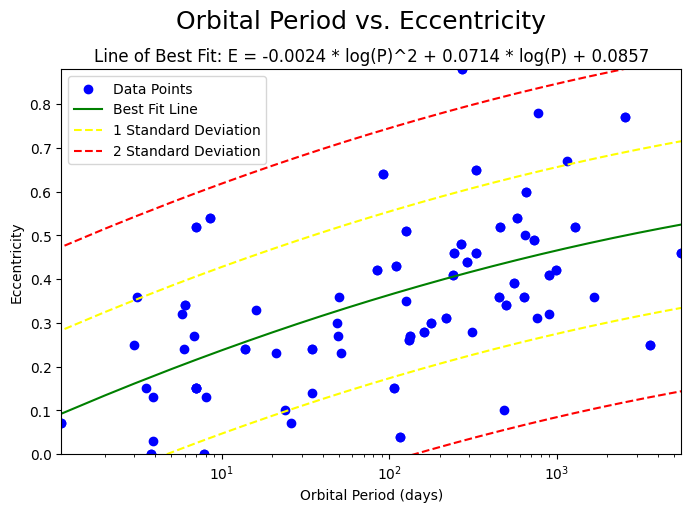

In [75]:
# Load data from Halbwachs list
Period_data = [2527.0, 13.8, 91.0, 114.8, 130.0, 727.4, 5512.0, 330.4, 330.4, 7.0, 7.0, 551.9, 161.1, 447.3, 243.7, 987.9, 3.8, 8.5, 241.0, 632.0, 1284.4, 271.1, 7.0, 3607.4, 266.3, 125.8, 889.9, 105.9, 1.1, 133.1, 34.7, 83.7, 289.0, 6.0, 110.0, 494.7, 177.0, 217.3, 650.3, 573.0,  454.7, 7.8, 2527.0, 13.8, 91.0, 114.8, 130.0, 727.4, 5512.0, 330.4, 330.4, 7.0, 7.0, 551.9, 161.1, 447.3, 243.7, 987.9, 3.8, 8.5, 241.0,632.0, 1284.4, 271.1, 7.0, 3607.4, 266.3, 125.8, 889.9, 105.9, 1.1, 133.1, 34.7, 83.7, 289.0, 6.0, 110.0, 494.7, 177.0, 217.3, 650.3, 573.0, 454.7, 7.8, 23.8, 15.9, 3.5, 3.0, 3.1, 774.0, 34.6, 21.0, 51.2, 312.4, 1659.0, 49.8, 3.9, 5.8, 647.6, 479.7, 757.1, 8.0, 26.0, 48.6, 6.8, 5.9, 49.0, 896.0, 126.0, 3.9, 1149.5]
Eccentricity_data = [0.77, 0.24, 0.64, 0.04, 0.26, 0.49, 0.46, 0.65, 0.46, 0.15,0.15, 0.39, 0.28, 0.36, 0.46, 0.42, 0.00, 0.54, 0.41, 0.36,0.52, 0.88, 0.52, 0.25, 0.48, 0.51, 0.41, 0.15, 0.07, 0.27,0.24, 0.42, 0.44, 0.34, 0.43, 0.34, 0.30, 0.31, 0.60, 0.54,0.52, 0.00, 0.77, 0.24, 0.64, 0.04, 0.26, 0.49, 0.46, 0.65, 0.46, 0.15, 0.15, 0.39, 0.28, 0.36, 0.46, 0.42, 0.00, 0.54, 0.41, 0.36, 0.52, 0.88, 0.52, 0.25, 0.48, 0.51, 0.41, 0.15, 0.07, 0.27, 0.24, 0.42, 0.44, 0.34, 0.43, 0.34, 0.30, 0.31,   0.60, 0.54, 0.52, 0.00, 0.10, 0.33, 0.15, 0.25, 0.36, 0.78,  0.14, 0.23, 0.23, 0.28, 0.36, 0.36, 0.03, 0.32, 0.50, 0.10, 0.31, 0.13, 0.07, 0.30, 0.27, 0.24, 0.27, 0.32, 0.35, 0.13, 0.67]

# Find line of best fit
degree = 2  # Linear fit
coeffs = np.polyfit(np.log(Period_data), (Eccentricity_data), degree)  # Log scale for x-axis
poly_eq = np.poly1d(coeffs)  # Convert to polynomial equation

# Generate x values for the best-fit line
x_vals = np.linspace(1,10000 , 10000)
y_vals = poly_eq(np.log(x_vals))  # Apply log to x-values
a, b, c = coeffs  # a = quadratic term, b = linear term, c = intercept

#Create dotted lines 1 & 2 standard deviations away from line of best fit
Error_line1 = poly_eq(np.log(x_vals)) + np.std(Eccentricity_data)
Error_line2 = Error_line1 + np.std(Eccentricity_data)
Error_line3 = poly_eq(np.log(x_vals)) - np.std(Eccentricity_data)
Error_line4 = Error_line3 - np.std(Eccentricity_data)

# Plot data points
plt.figure(figsize=(8,5))
plt.scatter(Period_data, Eccentricity_data, color='blue', label="Data Points")

# Plot best-fit line & the error lines assosciated  with it in color coded order
plt.plot(x_vals, y_vals, color='green', label="Best Fit Line")
plt.plot(x_vals, Error_line1, color='yellow', linestyle='--', label="1 Standard Deviation")
plt.plot(x_vals, Error_line2, color='red', linestyle='--', label="2 Standard Deviation")
plt.plot(x_vals, Error_line3, color='yellow', linestyle='--')
plt.plot(x_vals, Error_line4, color='red', linestyle='--')

# Set logarithmic scale
plt.xscale('log')
plt.xlabel("Orbital Period (days)")
plt.ylabel("Eccentricity")
plt.suptitle("Orbital Period vs. Eccentricity", y = 1, fontsize = 18)
plt.title("Line of Best Fit: E = " + str(round(a, 4)) + " * log(P)^2 + " + str(round(b, 4)) + " * log(P) + " + str(round(c, 4)), fontsize=12)
plt.xlim(np.min(Period_data), np.max(Period_data))
plt.ylim(np.min(Eccentricity_data), np.max(Eccentricity_data))
plt.legend()

# Show plot
plt.show()

#Save The line of best fit eccentricity equation for data point production
line_best_fit = poly_eq

From this graph we can see the green line (ideal) and the 1st and 2nd standard deviations away from that ideal. We will use this to randomly calculate varience in our new dataset from the period distribution.

From here we can generate data that fits the logarithmic curve and assign those values a eccentricity using the line of best fit above.

## 2.8 - Sanity Check 2




We also are doing several sanity checks here for our data including:
1.   We are setting the eccentricity for all binaries with periods less than 10 days to 0 as that is consistent with the literature we were given.

2.   We remove any negative eccentricity values from the list, alongside the period that corresponds to them. Negative eccentricity values can be generated in our simulation for very low periods due to our built-in uncertainty, but are impossible in nature, so we need to remove them. The same has been done for eccentricities greater than 1 as they are non-physical.

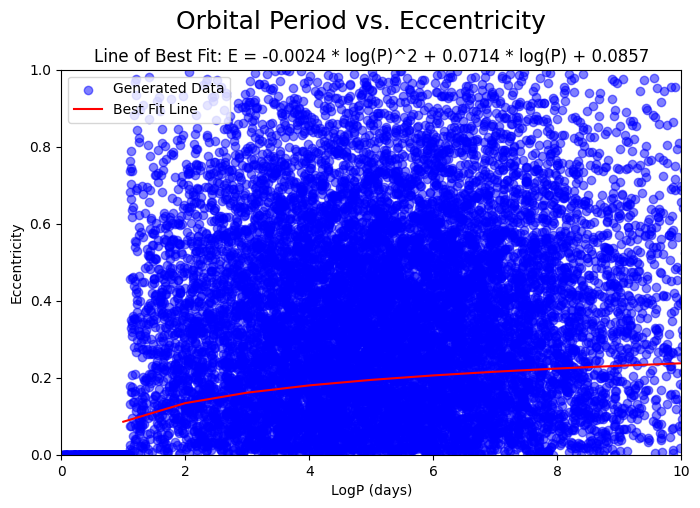

In [76]:
# Compute eccentricity using the best-fit equation
GED = []  # Generated Eccentricity Data

for P in sampledPeriods:
    if P < 1.1:
        GED.append(0)  # Assign 0 if period is too small, circular orbit
    else:
        eccentricity = poly_eq(np.log(P))  # Apply best-fit equation
        GED.append(eccentricity)


# use standard deviation of original data to create new distribution (we are going to get points within 2 standard deviations)
std_dev = np.std(Eccentricity_data)

# Add noise to eccentricities
GED_noisy = []
for i in range(len(sampledPeriods)):
    if sampledPeriods[i] < 1.1: #We need to remove periods above 1 because they cannot exist
        GED_noisy.append(0)
    else:
      noise_level = 2 #This determinies how significant the noise, we want 2 standard deviations
      noisy_eccentricity = GED[i] + np.random.normal(0,noise_level * std_dev)  # add noise
      GED_noisy.append(noisy_eccentricity)

#remove negatives
for i in range(len(GED_noisy)):
  if GED_noisy[i] < 0:
    GED_noisy[i] = np.nan
  elif GED_noisy[i] > 1:
    GED_noisy[i] = np.nan

indices = np.where(np.isnan(GED_noisy))
GED_noisy = np.delete(GED_noisy, indices)
#delete same indices from sampledPeriods
sampledPeriods = np.delete(sampledPeriods, indices)

# Scatter plot for Period vs. Eccentricity
plt.figure(figsize=(8, 5))
plt.scatter(sampledPeriods, GED_noisy, color='blue', alpha=0.5, label="Generated Data")
plt.plot(x_vals, y_vals, color='red', label="Best Fit Line")

# Set logarithmic scale for better visualization
plt.xlabel("LogP (days)")
plt.ylabel("Eccentricity")
plt.title("Line of Best Fit: E = " + str(round(a, 4)) + " * log(P)^2 + " + str(round(b, 4)) + " * log(P) + " + str(round(c, 4)), fontsize=12)
plt.suptitle("Orbital Period vs. Eccentricity", y=1, fontsize=18)
plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 1)

# Show scatter plot
plt.show()



## 2.9 - Sanity Check 3
Now, let's confirm that we got rid of nullified eccentricities.

This will help verify that we only have eccentricities that are greater than 0 & less than 1.

In [77]:
#sanity check
# Find indices where the period is 12 days or less
indices = np.where(np.array(sampledPeriods) <= 1.1)

# Print the corresponding eccentricities
print("Of the eccentricities that were changed to 0, the max is: " + str(np.max(np.array(GED_noisy)[indices])))
print("The minimum value of our eccentricities is: " + str(np.min(np.array(GED_noisy))))
print("The maximum value of our eccentricities is: " + str(np.max(np.array(GED_noisy))))

Of the eccentricities that were changed to 0, the max is: 0.0
The minimum value of our eccentricities is: 0.0
The maximum value of our eccentricities is: 0.9990964771514235


# Part 3 - Modeling Orbits

## 3.1 - Distributions Based on Perspective

Now that we have the basic stats for our system, we need to model the orbits from a given perspective. To do this, we'll need to create random values for the argument of periapse (ω) and inclination (more specifically, cosine of inclination cos(I)). The argument of periapsis is an angle that describes the orientation of an elliptical orbit while inclination is the angle between the plane of the two stars' orbit and the plane perpendicular to the line of sight of the observer. These parameters will vary from 0 to 360 and -1 to 1, respectively. These vary with the position of the observer, and so are entirely independent of other properties, meaning we can simply model them with uniform distributions.

In [78]:
#Create a uniform distribution for ω, turn it into an array
ωArray = 360*(np.random.rand(1, num_samples))

#Create a uniform distribution for cosI
cosIList = []
for i in range(num_samples):
  #Generate a number 0-1
  randomNo = np.random.rand()

  #Randomly decide if that number will be negative
  negative = np.random.rand()
  if negative > 0.5:
    randomNo = randomNo*(-1)

  #Now we have a random value from -1 to 1!
  cosIList.append(randomNo)

cosIArray = np.array(cosIList)


## 3.2 - Why is cos(I) uniform, and not I?

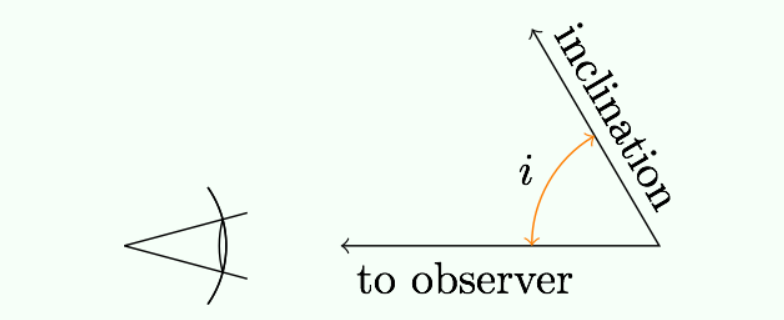

One may expect the inclination angles to be uniformly distributed in I, but they are actually uniformly distributed in cos(I). Why is this? This is primarily due to the nature of the problem that we are dealing with. When discussing things such as orbits, stellar rotation axes, or anything that exhibits spherical symmetry to a certain degree, it is beneficial to work in spherical coordinates. Inclination is an isotropic probability density function meaning that all values of inclination are equally likely. In order to project the isotropic uniformity of inclination from a sphere onto a single axis, cosine is implimented.

## 3.3 - Puting Our Distributions in a Pandas Dataframe

We can use a pandas dataframe to store all of our distributions together, giving us easier access to them. We can also display all of the data together!

In [79]:
# make sampled periods same length as secondary mass arrays
sampledPeriods = sampledPeriods[:len(secondaryMassArray)]
GED_noisy = GED_noisy[:len(secondaryMassArray)]
omega = ωArray[0,:][:len(secondaryMassArray)]
cosIArray = cosIArray[:len(secondaryMassArray)]
data = {
    'primary_mass': primaryMassArray,
    'secondary_mass': secondaryMassArray,
    'mass_ratio': massRatioArray,
    'primary_radius': primaryRadiusArray,
    'secondary_radius': secondaryRadiusArray,
    'period': sampledPeriods,
    'eccentricity': GED_noisy,
    'omega': omega,  # Access the first row of ωArray
    'cos_inclination': cosIArray
}

# Create the DataFrame
df = pd.DataFrame(data)
# Display the DataFrame
df


,primary_mass,secondary_mass,mass_ratio,primary_radius,secondary_radius,period,eccentricity,omega,cos_inclination
0,0.110441,0.094803,0.858405,0.171595,0.151865,6.625560,0.802641,316.142176,0.349942
1,0.100000,0.095603,0.956032,0.158489,0.152890,5.007838,0.085155,303.139479,-0.890744
2,1.614241,1.329805,0.823795,1.288912,1.163075,2.669629,0.004736,136.837764,0.055893
3,0.124942,0.095152,0.761568,0.189395,0.152312,4.693377,0.168405,0.850176,0.578051
4,0.218622,0.161879,0.740454,0.296316,0.232999,7.593566,0.320241,331.060073,0.131592
...,...,...,...,...,...,...,...,...,...
9995,0.236604,0.115677,0.488908,0.315658,0.178073,6.072518,0.697866,333.461138,0.659503
9996,0.100870,0.100524,0.996572,0.159592,0.159154,3.280675,0.074752,122.924168,-0.668171
9997,0.319262,0.270344,0.846779,0.401160,0.351183,6.113740,0.154495,145.250501,0.107154
9998,0.269957,0.191683,0.710049,0.350781,0.266727,2.426852,0.928342,17.669497,-0.707407


## 3.4 - Sanity Check 4 (Colliding Binaries)

After taking a look at our sampled parameters in the dataframe, we see that there may be a couple of non-physical combinations that we haven't accounted for. Since the normal distribution spans any possible value, it's possible that we could have a system with such a period that the resulting semi-major axis is smaller than the radii of the stars. Since these cases - in which the stars would crash into each other - would look like eclipsing binaries in our model, but certainly not behave like them in practice, we need to check for them and weed them out:

In [80]:
#Loop over each of the binaries
crashCount = 0
indices_to_remove = []

for i in range(len(df)):
  #Get the period, total mass, eccentricity, and semi-major axis of the system
  timeYears = (10**sampledPeriods[i])/365 #Period in years
  totalMass = (df.loc[i, 'primary_mass'] + df.loc[i, 'secondary_mass']) #total mass, in solar masses
  eccentricity = df.loc[i, 'eccentricity'] #Eccentricity, no units
  semiMajorAxis = (((timeYears**2)*totalMass)**(1/3))*au2m #Semi-major axis in meters

  #find the periapsis of the system (the point in the orbit when the two stars are closest to each other)
  periapsis =  semiMajorAxis*(1-eccentricity)

  #Find the sum of the radii in the system - if it's greater than the length of the periapsis, the stars are going to touch at some point in their orbit.
  sumOfRadii = (df.loc[i, 'primary_radius']*rSun_m) + df.loc[i, 'secondary_radius']*rSun_m #Sum of the stars' radii in meters
  if periapsis < sumOfRadii:
    crashCount += 1
    indices_to_remove.append(i)  # Add the index to the removal list

# Drop all the crashing binaries after the loop
df = df.drop(indices_to_remove).reset_index(drop=True)

print("There were", crashCount, "binaries in which the stars crashed into each other. They have now been removed.")
#check row number in dataframe, originally 10,000
print("Rows in dataframe: " + str(len(df)))

There were 2 binaries in which the stars crashed into each other. They have now been removed.
Rows in dataframe: 9998


This should only be around 0-3 binaries, so it's unlikely that our data will be greatly skewed by them, but it's useful to remove them anyway.

## 3.5 - Creating a Graphical Represenation of a Binary

Now we create a graph modeling one of these orbits with aid from the code within the '3d_binary_geometry' jupyter notebook. Some notes on this - first, this graph is not to scale; rather, the dots are scaled to the graph to ensure that they are visible even for systems with very large semi-major axes. Also, we are modeling the binary as a moving secondary star orbiting a stationary primary - in reality, both stars orbit a single center of mass. However, an eliptical orbit is sufficient to model their *relative* motion, as long as one remembers that from the standpoint of other objects, they would both be moving.

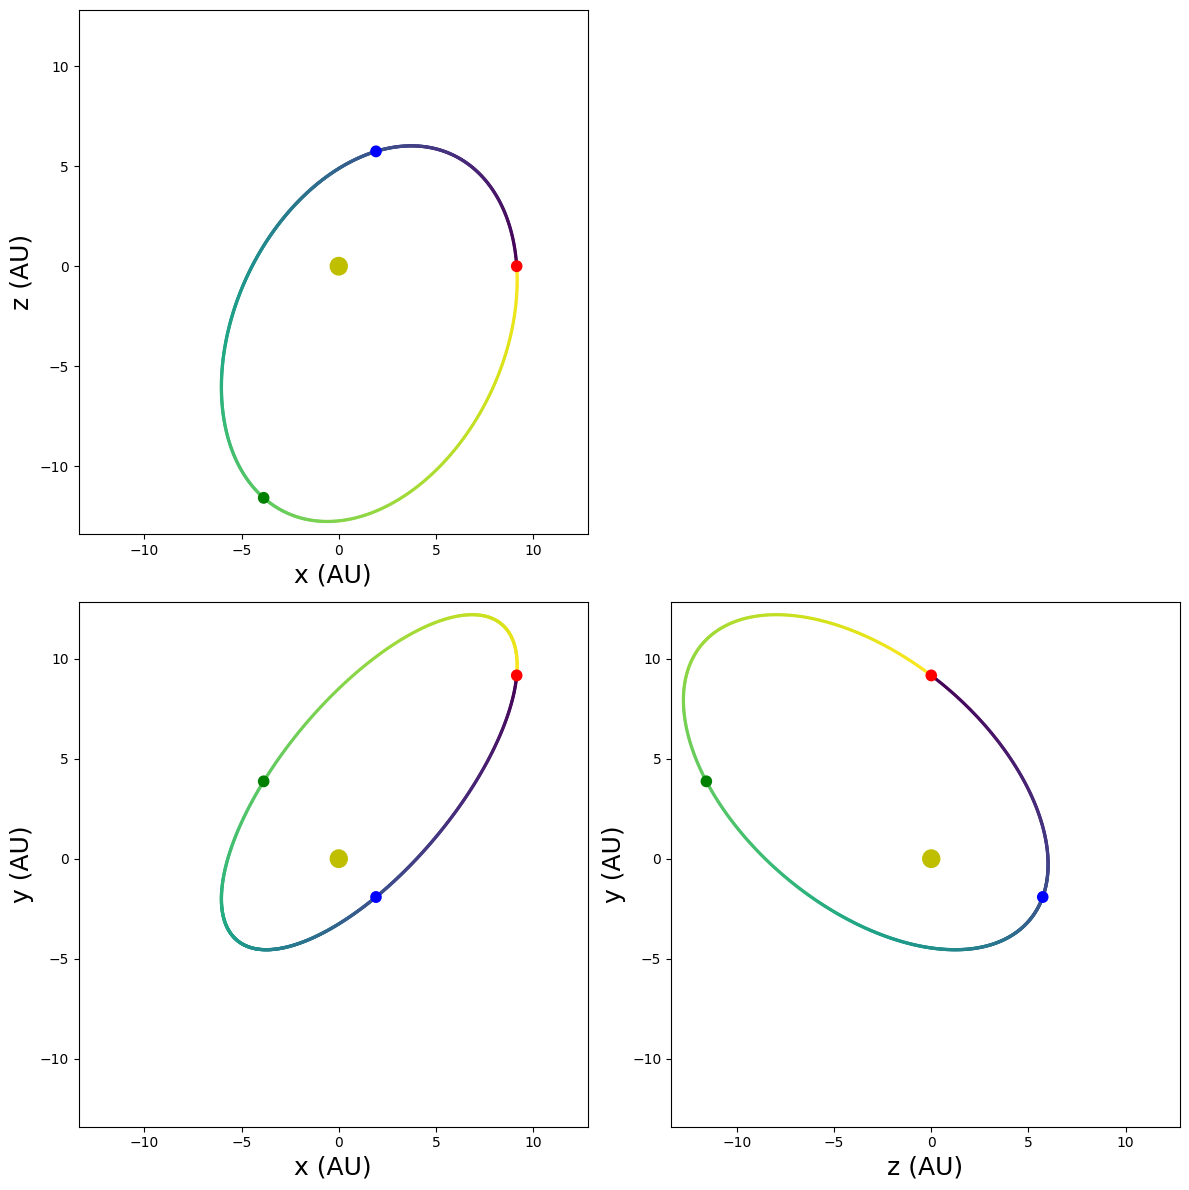

In [81]:
#We will be modeling these systems with the primary star as a stationary point that the secondary star orbits,
#when in reality they both orbit a center of mass
#choose random index in our dataframe
chosenIndex = np.random.randint(0, len(secondaryMassArray))

def binaryFormation(chosenIndex):
  R1 = df.loc[chosenIndex, 'primary_radius'] * rSun_m # radius of star A, in metres (the primary star)
  R2 = df.loc[chosenIndex, 'secondary_radius'] * rSun_m # radius of star B, in metres (the secondary star)

  timeyears = (10**sampledPeriods[chosenIndex]) / 365 #years

  #calculate semi-major axis via kepler's third law
  M = (df.loc[chosenIndex, 'primary_mass'] + df.loc[chosenIndex, 'secondary_mass'])#in solar masses
  a = (((timeyears**2) * M ) ** (1/3)) * au2m# semi-major axis of the binary, in metres

  e = df.loc[chosenIndex, 'eccentricity'] # eccentricity of the binary (unitless)
  I = np.arccos(df.loc[chosenIndex, 'cos_inclination']) # inclination of the binary, in radians
  Omega = np.radians(45) # longitude of the ascending node of the binary, in radians
  omega = np.radians(df.loc[chosenIndex, 'omega']) # argument of periapse of the binary, in radians

  num_steps = 1000
  theta = np.linspace(0,2*np.pi,num_steps) # true longitude, in radians, which is calculate as an array of length num_steps

  return R1, R2, a, e, I, Omega, omega, theta

R1, R2, a, e, I, Omega, omega, theta = binaryFormation(chosenIndex)

# Calculate the orbits
def calc_pos(theta,a,e,omega,Omega,I):
    # the line below is Kepler's 1st law because it shows that the relative distance between the centres of each star, r, follows an ellipse
    r = a*(1-e**2.)/(1+e*np.cos(theta-omega)) # the relative distance between the centres of each star
    # Calculate the 3d positions as a function of theta
    x = r*(np.cos(Omega)*np.cos(theta) - np.sin(Omega)*np.sin(theta) * np.cos(I))
    y = r*(np.sin(Omega)*np.cos(theta) + np.cos(Omega)*np.sin(theta) * np.cos(I))
    z = r*np.sin(theta)*np.sin(I)
    return [x,y,z]

positions = calc_pos(theta,a,e,omega,Omega,I)

x = positions[0] # x over the orbit
y = positions[1] # y over the orbit
z = positions[2] # z over the orbit

# calculate the start position of the secondary star

position_primary_eclipse = calc_pos(np.radians(90),a,e,omega,Omega,I)
position_secondary_eclipse = calc_pos(np.radians(270),a,e,omega,Omega,I)
position_start = calc_pos(0,a,e,omega,Omega,I)

# Figure out the axis limits so they are all the same

axis_min = np.min(np.array([np.min(x),np.min(y),np.min(z)]))/au2m * 1.05
axis_max = np.max(np.array([np.max(x),np.max(y),np.max(z)]))/au2m * 1.05

#calculate our scale factor so that we can actually see all the stars regardless of stellar radii
scaleFactor = axis_max - axis_min

# Plot the orbit with different projections
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(221)
ax.scatter(x/au2m,z/au2m,c = theta,s=2) # setting the colour to equal the true longitude theta, so you can see where you start and end
star1circle = plt.Circle((0, 0), scaleFactor/60, color='y') # A circle to represent the size of the primary star
star2circle = plt.Circle((position_start[0]/au2m,position_start[2]/au2m), scaleFactor/100, color='r') # a circle to represent the size of the secondary star, at its starting point
star2circle_primary_eclipse = plt.Circle((position_primary_eclipse[0]/au2m,position_primary_eclipse[2]/au2m), scaleFactor/100, color='b') # a circle to represent the size of the secondary star, when a primary eclipse could occur
star2circle_secondary_eclipse = plt.Circle((position_secondary_eclipse[0]/au2m,position_secondary_eclipse[2]/au2m), scaleFactor/100, color='g') # a circle to represent the size of the secondary star, when a secondary eclipse could occur
ax.add_patch(star1circle)
ax.add_patch(star2circle)
ax.add_patch(star2circle_primary_eclipse)
ax.add_patch(star2circle_secondary_eclipse)
ax.set_xlabel('x (AU)',fontsize=18)
ax.set_ylabel('z (AU)',fontsize=18)
ax.set_xlim([axis_min,axis_max])
ax.set_ylim([axis_min,axis_max])
#ax.axis('equal')
ax = fig.add_subplot(223)
ax.scatter(x/au2m,y/au2m,c = theta,s=2) # setting the colour to equal the true longitude theta, so you can see where you start and end
star1circle = plt.Circle((0, 0), scaleFactor/60, color='y') # A circle to represent the size of the primary star
star2circle = plt.Circle((position_start[0]/au2m,position_start[1]/au2m), scaleFactor/100, color='r') # a circle to represent the size of the secondary star, at its starting point
star2circle_primary_eclipse = plt.Circle((position_primary_eclipse[0]/au2m,position_primary_eclipse[1]/au2m), scaleFactor/100, color='b') # a circle to represent the size of the secondary star, when a primary eclipse could occur
star2circle_secondary_eclipse = plt.Circle((position_secondary_eclipse[0]/au2m,position_secondary_eclipse[1]/au2m), scaleFactor/100, color='g') # a circle to represent the size of the secondary star, when a secondary eclipse could occur
ax.add_patch(star1circle)
ax.add_patch(star2circle)
ax.add_patch(star2circle_primary_eclipse)
ax.add_patch(star2circle_secondary_eclipse)
ax.set_xlabel('x (AU)',fontsize=18)
ax.set_ylabel('y (AU)',fontsize=18)
ax.set_xlim([axis_min,axis_max])
ax.set_ylim([axis_min,axis_max])
#ax.axis('equal')
ax = fig.add_subplot(224)
ax.scatter(z/au2m,y/au2m,c = theta,s=2) # setting the colour to equal the true longitude theta, so you can see where you start and end
star1circle = plt.Circle((0, 0), scaleFactor/60, color='y') # A circle to represent the size of the primary star
star2circle = plt.Circle((position_start[2]/au2m,position_start[1]/au2m), scaleFactor/100, color='r') # a circle to represent the size of the secondary star, at its starting point
star2circle_primary_eclipse = plt.Circle((position_primary_eclipse[2]/au2m,position_primary_eclipse[1]/au2m), scaleFactor/100, color='b') # a circle to represent the size of the secondary star, when a primary eclipse could occur
star2circle_secondary_eclipse = plt.Circle((position_secondary_eclipse[2]/au2m,position_secondary_eclipse[1]/au2m), scaleFactor/100, color='g') # a circle to represent the size of the secondary star, when a secondary eclipse could occur
ax.add_patch(star1circle)
ax.add_patch(star2circle)
ax.add_patch(star2circle_primary_eclipse)
ax.add_patch(star2circle_secondary_eclipse)
ax.set_xlabel('z (AU)',fontsize=18)
ax.set_ylabel('y (AU)',fontsize=18)
ax.set_xlim([axis_min,axis_max])
ax.set_ylim([axis_min,axis_max])
#ax.axis('equal')
plt.tight_layout()
plt.show()

# Part 4 - Finding and Examining at the Eclipsing Binary Population

## 4.1  - Identifying Eclipsing Binaries

By iterating over the entire binary star list and checking if the seperation of the stars is less than the sum of the two radii, we can find the number of eclipsing binaries. We also have the ability to identify whether it is a primary eclipse or a secondary eclipse occurring. The primary eclipse, defined as the secondary, less massive star passing in front of the primary, more massive star, occurs when the z-component of position is positive in our convention. In contrast, the secondary eclipse when the secondary star is the one being eclipsed by the primary, occurs when the z-component of position is negative. This is due to our eclipses being defined within the x-y plane, allowing us to identify whether the secondary star is in-front of or behind the primary star by looking at the z-axis.

In [82]:
#Look over our events, identify eclipses, and find the percentage of the total that eclipse
eclipsingBinaries = []
primSecArray = []
primary_eclipse_count = 0
secondary_eclipse_count = 0

for i in range(len(df)):
  R1, R2, a, e, I, Omega, omega, theta = binaryFormation(i)
  positions = calc_pos(theta,a,e,omega,Omega,I)
  x = positions[0] # x over the orbit
  y = positions[1] # y over the orbit
  z = positions[2] # z over the orbit
  s = ((x)**2. + (y)**2.)**0.5
  if np.min(s)<(R1+R2):
    eclipsingBinaries.append(i)

    # Now, lets look at which type of eclipse occurs
    # Find the index where the minimum separation occurs
    min_index = np.argmin(s)

    # Initialize variables to track if an eclipse has been counted
    primary_eclipses_in_this_orbit = 0
    secondary_eclipses_in_this_orbit = 0

    # Loop through the positions to check when separation crosses the radii threshold
    for j in range(1, len(s)):
        # Check if we crossed the threshold (separation < R1 + R2)
        if s[j-1] > (R1 + R2) and s[j] <= (R1 + R2):  # Crossing threshold from more to less than or equal
            if z[j] > 0 and primary_eclipses_in_this_orbit == 0:  # Primary eclipse (secondary in front, yellow circle has contact with blue circle)
                primary_eclipses_in_this_orbit += 1
                primary_eclipse_count += 1
            elif z[j] < 0 and secondary_eclipses_in_this_orbit == 0:  # Secondary eclipse (primary in front, yellow circle has contact with green circle)
                secondary_eclipses_in_this_orbit += 1
                secondary_eclipse_count += 1

        # Exit loop early if both eclipses are detected for this orbit
        if primary_eclipses_in_this_orbit == 1 and secondary_eclipses_in_this_orbit == 1:
          primSecArray.append(i)
          break

# Print results
print("Total Eclipsing Binaries:", len(eclipsingBinaries))
print("Total Eclpising Binaries Percentage: " + str((len(eclipsingBinaries)/len(df))*100) + "%\n")
print("Primary Eclipses:", primary_eclipse_count)
print("Secondary Eclipses:", secondary_eclipse_count)
print("Total Eclipses: " + str(primary_eclipse_count + secondary_eclipse_count) + "\n")
print("Primary Eclipse Percentage: " + str((primary_eclipse_count / (primary_eclipse_count + secondary_eclipse_count)) * 100) + "%")
print("Secondary Eclipse Percentage: " + str((secondary_eclipse_count / (primary_eclipse_count + secondary_eclipse_count)) * 100) + "%")


Total Eclipsing Binaries: 82
Total Eclpising Binaries Percentage: 0.8201640328065612%

Primary Eclipses: 63
Secondary Eclipses: 66
Total Eclipses: 129

Primary Eclipse Percentage: 48.837209302325576%
Secondary Eclipse Percentage: 51.162790697674424%


## 4.2 - Graphing an Eclipsing Binary

If we want to see what one of these binaries looks like, we can use a similar program to our code from above to examine it:

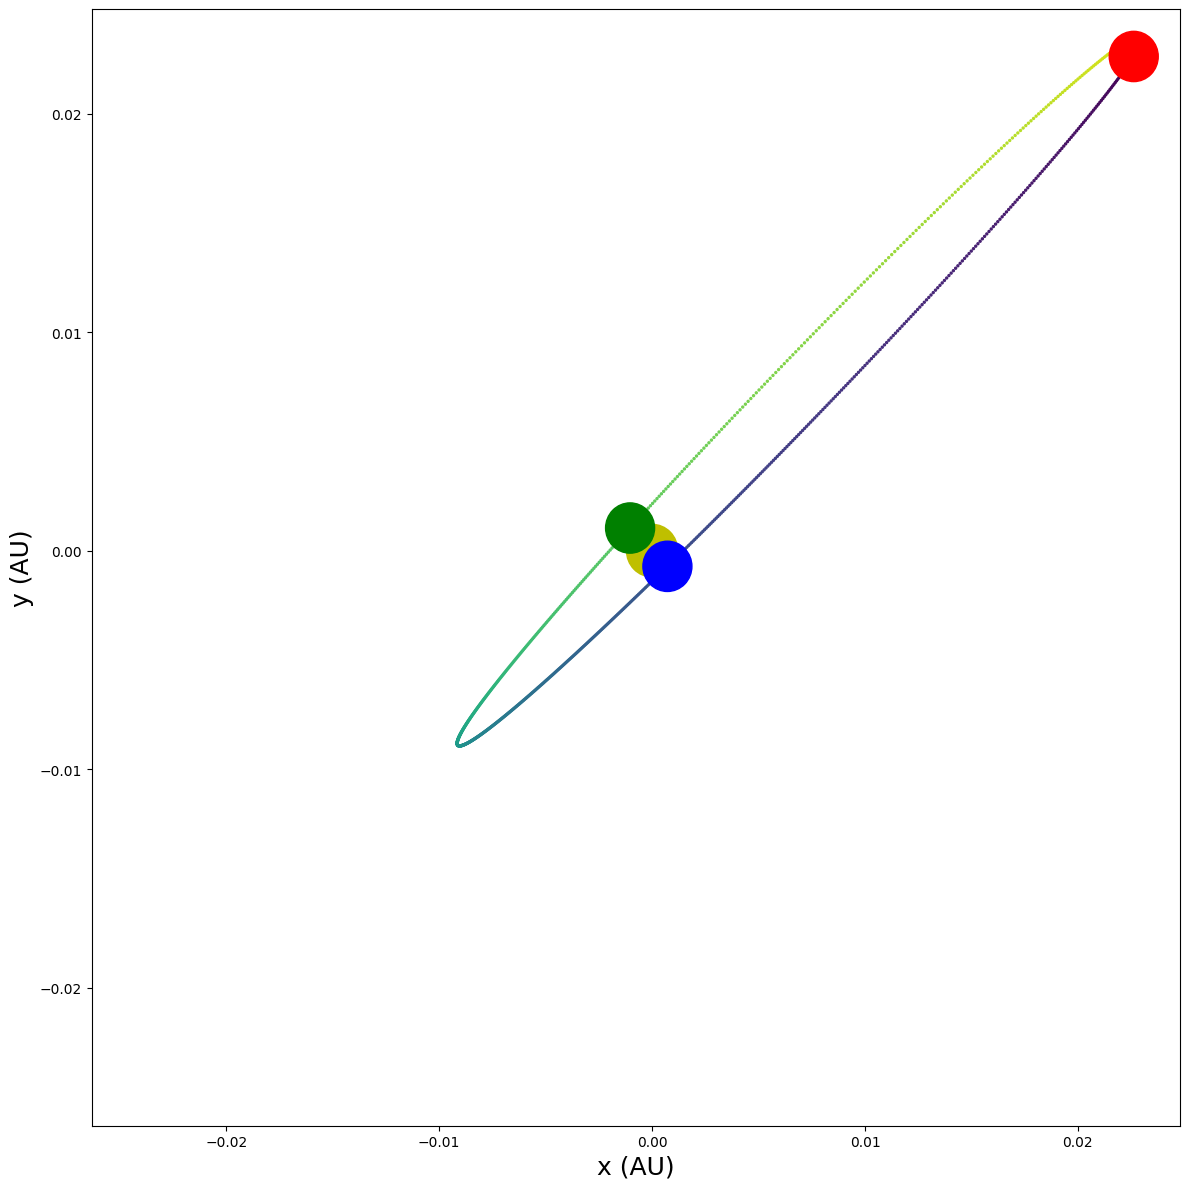

Eclipsing Binary Index: 3143
Eclipse Type: Primary and Secondary Eclipse

Primary Mass (solar mass): 0.1843984398439844
Secondary Mass (solar mass): 0.17429261683031608
Mass Ratio: 0.9451957238780402

Primary Radius (solar radii): 0.2585864677527954
Secondary Radius (solar radii): 0.24718561445004897

Eccentricity: 0.4707225826501047
Log of Period (days): 4.804824948249483


In [83]:
#loop through indices of eclipsing binaries and radnomly graph one
eclipseIndex = np.random.randint(0, len(eclipsingBinaries))
eclipseIndexII = eclipsingBinaries[eclipseIndex]
R1, R2, a, e, I, Omega, omega, theta = binaryFormation(eclipseIndexII)

# Calculate the orbits
def calc_pos(theta,a,e,omega,Omega,I):
    # the line below is Kepler's 1st law because it shows that the relative distance between the centres of each star, r, follows an ellipse
    r = a*(1-e**2.)/(1+e*np.cos(theta-omega)) # the relative distance between the centres of each star
    # Calculate the 3d positions as a function of theta
    x = r*(np.cos(Omega)*np.cos(theta) - np.sin(Omega)*np.sin(theta) * np.cos(I))
    y = r*(np.sin(Omega)*np.cos(theta) + np.cos(Omega)*np.sin(theta) * np.cos(I))
    z = r*np.sin(theta)*np.sin(I)
    return [x,y,z]

positions = calc_pos(theta,a,e,omega,Omega,I)

x = positions[0] # x over the orbit
y = positions[1] # y over the orbit
z = positions[2] # z over the orbit

# Get indice of minimum separation to find out if it is a secondary or primary eclipse
s = ((x)**2. + (y)**2.)**0.5
min_index = np.argmin(s)

# calculate the start position of the secondary star

position_primary_eclipse = calc_pos(np.radians(90),a,e,omega,Omega,I)
position_secondary_eclipse = calc_pos(np.radians(270),a,e,omega,Omega,I)
position_start = calc_pos(0,a,e,omega,Omega,I)

# Figure out the axis limits so they are all the same

axis_min = np.min(np.array([np.min(x),np.min(y),np.min(z)]))/au2m * 1.05
axis_max = np.max(np.array([np.max(x),np.max(y),np.max(z)]))/au2m * 1.05

# Plot the orbit with different projections
fig = plt.figure(figsize=(12,12))
#ax.axis('equal')
ax = fig.add_subplot(111)
ax.scatter(x/au2m,y/au2m,c = theta,s=2) # setting the colour to equal the true longitude theta, so you can see where you start and end
star1circle = plt.Circle((0, 0), R1/au2m, color='y') # A circle to represent the size of the primary star
star2circle = plt.Circle((position_start[0]/au2m,position_start[1]/au2m), R2/au2m, color='r') # a circle to represent the size of the secondary star, at its starting point
star2circle_primary_eclipse = plt.Circle((position_primary_eclipse[0]/au2m,position_primary_eclipse[1]/au2m), R2/au2m, color='b') # a circle to represent the size of the secondary star, when a primary eclipse could occur
star2circle_secondary_eclipse = plt.Circle((position_secondary_eclipse[0]/au2m,position_secondary_eclipse[1]/au2m), R2/au2m, color='g') # a circle to represent the size of the secondary star, when a secondary eclipse could occur
ax.add_patch(star1circle)
ax.add_patch(star2circle)
ax.add_patch(star2circle_primary_eclipse)
ax.add_patch(star2circle_secondary_eclipse)
ax.set_xlabel('x (AU)',fontsize=18)
ax.set_ylabel('y (AU)',fontsize=18)
ax.set_xlim([axis_min,axis_max])
ax.set_ylim([axis_min,axis_max])

plt.tight_layout()
plt.show()

#Printing the binary's index, in case we want to inspect it more closely
print("Eclipsing Binary Index: " + str(eclipsingBinaries[eclipseIndex]))
#print if primary or secondary eclipse
if z[min_index] > 0 and eclipseIndexII not in primSecArray:
  print("Eclipse Type: Primary Eclipse\n")
elif z[min_index] < 0 and eclipseIndexII not in primSecArray:
  print("Eclipse Type: Secondary Eclipse\n")
elif eclipseIndexII in primSecArray:
  print("Eclipse Type: Primary and Secondary Eclipse\n")

#General data about the binary
print("Primary Mass (solar mass): " + str(df.loc[eclipsingBinaries[eclipseIndex], 'primary_mass']))
print("Secondary Mass (solar mass): " + str(df.loc[eclipsingBinaries[eclipseIndex], 'secondary_mass']))
print("Mass Ratio: " + str(df.loc[eclipsingBinaries[eclipseIndex], 'mass_ratio']) + "\n")
print("Primary Radius (solar radii): " + str(df.loc[eclipsingBinaries[eclipseIndex], 'primary_radius']))
print("Secondary Radius (solar radii): " + str(df.loc[eclipsingBinaries[eclipseIndex], 'secondary_radius']) + "\n")
print("Eccentricity: " + str(df.loc[eclipsingBinaries[eclipseIndex], 'eccentricity']))
print("Log of Period (days): " + str(df.loc[eclipsingBinaries[eclipseIndex], 'period']))



## 4.3 - A Closer Look at the Conditions for an Eclipse

Let's take a closer look at the separation value that we used to identify eclipses in our binaries.

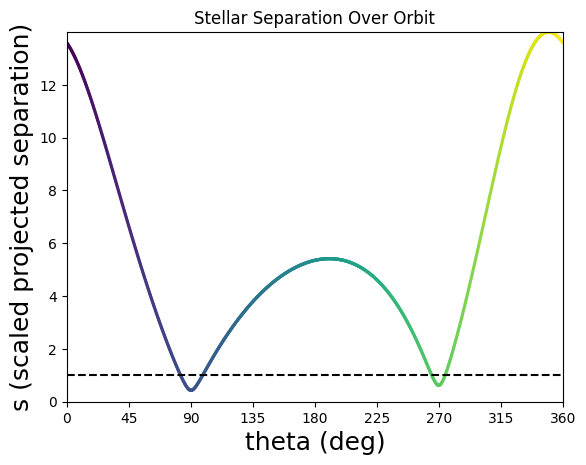

In [84]:
#Looking at the 3d binary geometry notebook we can get the conditions for an eclipse
#define an array with all seperation values
sep = []  #store separation values

#the s, R1, R2, and theta values are being taken from the binary shown in subplot(111) in the cell above

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.degrees(theta),s/(R1 + R2),c = theta,s=2)
ax.plot([0, 360], [1, 1], 'k--') #should the separation reach the dashed line, an eclipse will occur
ax.set_xlabel('theta (deg)', fontsize=18)
ax.set_ylabel('s (scaled projected separation)', fontsize=18)
ax.set_xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
ax.set_ylim([0, np.max(np.array(s) / (R1 + R2))])
ax.set_title('Stellar Separation Over Orbit')
max = np.max(np.array(s) / (R1 + R2))
ax.set_xlim([0, 360])
plt.show()


## 4.4 - What About Omega?


Now, for these models, you may be wondering why we can get away with setting Omega to 45 radians instead of generating a distribution - the reason is that Omega determines the rotation of the event in the x-y plane. Since this doesn't change the orientation of the stars relative to each other in the x-y plane, this has no effect on whether the binary eclipses or not - and in the rest of this notebook, that will be the main factor we're interested in. We can demonstrate this by graphing this same event with a few different values of Omega:

(-0.026324469453523545, 0.02479399557107425)

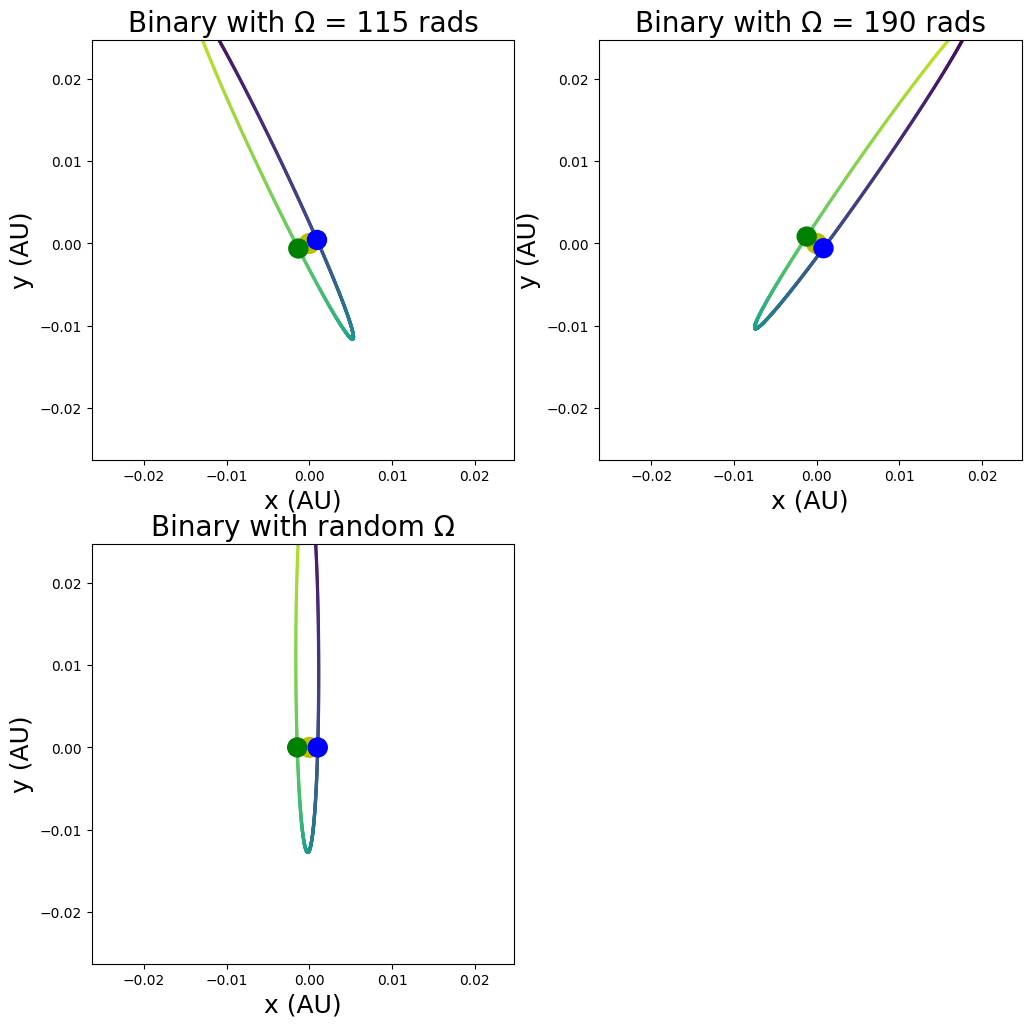

In [85]:
#Make a new figure
fig = plt.figure(figsize=(12,12))

R1, R2, a, e, I, Omega, omega, theta = binaryFormation(eclipseIndexII)

#Change Omega to 115 radians, recalculate positions
Omega = np.radians(115) # longitude of the ascending node of the binary, in radians
positions = calc_pos(theta,a,e,omega,Omega,I)
x = positions[0] # x over the orbit
y = positions[1] # y over the orbit
z = positions[2] # z over the orbit
position_primary_eclipse = calc_pos(np.radians(90),a,e,omega,Omega,I)
position_secondary_eclipse = calc_pos(np.radians(270),a,e,omega,Omega,I)
position_start = calc_pos(0,a,e,omega,Omega,I)

ax = fig.add_subplot(221)
ax.set_title("Binary with Ω = 115 rads", fontsize = 20)
ax.scatter(x/au2m,y/au2m,c = theta,s=2) # setting the colour to equal the true longitude theta, so you can see where you start and end
star1circle = plt.Circle((0, 0), R1/au2m, color='y') # A circle to represent the size of the primary star
star2circle = plt.Circle((position_start[0]/au2m,position_start[1]/au2m), R2/au2m, color='r') # a circle to represent the size of the secondary star, at its starting point
star2circle_primary_eclipse = plt.Circle((position_primary_eclipse[0]/au2m,position_primary_eclipse[1]/au2m), R2/au2m, color='b') # a circle to represent the size of the secondary star, when a primary eclipse could occur
star2circle_secondary_eclipse = plt.Circle((position_secondary_eclipse[0]/au2m,position_secondary_eclipse[1]/au2m), R2/au2m, color='g') # a circle to represent the size of the secondary star, when a secondary eclipse could occur
ax.add_patch(star1circle)
ax.add_patch(star2circle)
ax.add_patch(star2circle_primary_eclipse)
ax.add_patch(star2circle_secondary_eclipse)
ax.set_xlabel('x (AU)',fontsize=18)
ax.set_ylabel('y (AU)',fontsize=18)
ax.set_xlim([axis_min,axis_max])
ax.set_ylim([axis_min,axis_max])


#Change Omega to 190 radians, then recalculate again

Omega = np.radians(55) # longitude of the ascending node of the binary, in radians
positions = calc_pos(theta,a,e,omega,Omega,I)
x = positions[0] # x over the orbit
y = positions[1] # y over the orbit
z = positions[2] # z over the orbit
position_primary_eclipse = calc_pos(np.radians(90),a,e,omega,Omega,I)
position_secondary_eclipse = calc_pos(np.radians(270),a,e,omega,Omega,I)
position_start = calc_pos(0,a,e,omega,Omega,I)

ax = fig.add_subplot(222)
ax.set_title("Binary with Ω = 190 rads", fontsize = 20)
ax.scatter(x/au2m,y/au2m,c = theta,s=2) # setting the colour to equal the true longitude theta, so you can see where you start and end
star1circle = plt.Circle((0, 0), R1/au2m, color='y') # A circle to represent the size of the primary star
star2circle = plt.Circle((position_start[0]/au2m,position_start[1]/au2m), R2/au2m, color='r') # a circle to represent the size of the secondary star, at its starting point
star2circle_primary_eclipse = plt.Circle((position_primary_eclipse[0]/au2m,position_primary_eclipse[1]/au2m), R2/au2m, color='b') # a circle to represent the size of the secondary star, when a primary eclipse could occur
star2circle_secondary_eclipse = plt.Circle((position_secondary_eclipse[0]/au2m,position_secondary_eclipse[1]/au2m), R2/au2m, color='g') # a circle to represent the size of the secondary star, when a secondary eclipse could occur
ax.add_patch(star1circle)
ax.add_patch(star2circle)
ax.add_patch(star2circle_primary_eclipse)
ax.add_patch(star2circle_secondary_eclipse)
ax.set_xlabel('x (AU)',fontsize=18)
ax.set_ylabel('y (AU)',fontsize=18)
ax.set_xlim([axis_min,axis_max])
ax.set_ylim([axis_min,axis_max])


#Now let's make it completely random!
np.random.seed()
randomNo = np.random.rand()
Omega = np.radians((randomNo)*100) # longitude of the ascending node of the binary, in radians
positions = calc_pos(theta,a,e,omega,Omega,I)
x = positions[0] # x over the orbit
y = positions[1] # y over the orbit
z = positions[2] # z over the orbit
position_primary_eclipse = calc_pos(np.radians(90),a,e,omega,Omega,I)
position_secondary_eclipse = calc_pos(np.radians(270),a,e,omega,Omega,I)
position_start = calc_pos(0,a,e,omega,Omega,I)

ax = fig.add_subplot(223)
ax.set_title("Binary with random Ω", fontsize = 20)
ax.scatter(x/au2m,y/au2m,c = theta,s=2) # setting the colour to equal the true longitude theta, so you can see where you start and end
star1circle = plt.Circle((0, 0), R1/au2m, color='y') # A circle to represent the size of the primary star
star2circle = plt.Circle((position_start[0]/au2m,position_start[1]/au2m), R2/au2m, color='r') # a circle to represent the size of the secondary star, at its starting point
star2circle_primary_eclipse = plt.Circle((position_primary_eclipse[0]/au2m,position_primary_eclipse[1]/au2m), R2/au2m, color='b') # a circle to represent the size of the secondary star, when a primary eclipse could occur
star2circle_secondary_eclipse = plt.Circle((position_secondary_eclipse[0]/au2m,position_secondary_eclipse[1]/au2m), R2/au2m, color='g') # a circle to represent the size of the secondary star, when a secondary eclipse could occur
ax.add_patch(star1circle)
ax.add_patch(star2circle)
ax.add_patch(star2circle_primary_eclipse)
ax.add_patch(star2circle_secondary_eclipse)
ax.set_xlabel('x (AU)',fontsize=18)
ax.set_ylabel('y (AU)',fontsize=18)
ax.set_xlim([axis_min,axis_max])
ax.set_ylim([axis_min,axis_max])

## 4.5 - Range of Visibility for an Eclipse

As we have demonstrated, very few binary systems actually eclipse from any given angle. To find the portion of angles from which the eclipse is visible, we can take a look at the geometry of these systems:

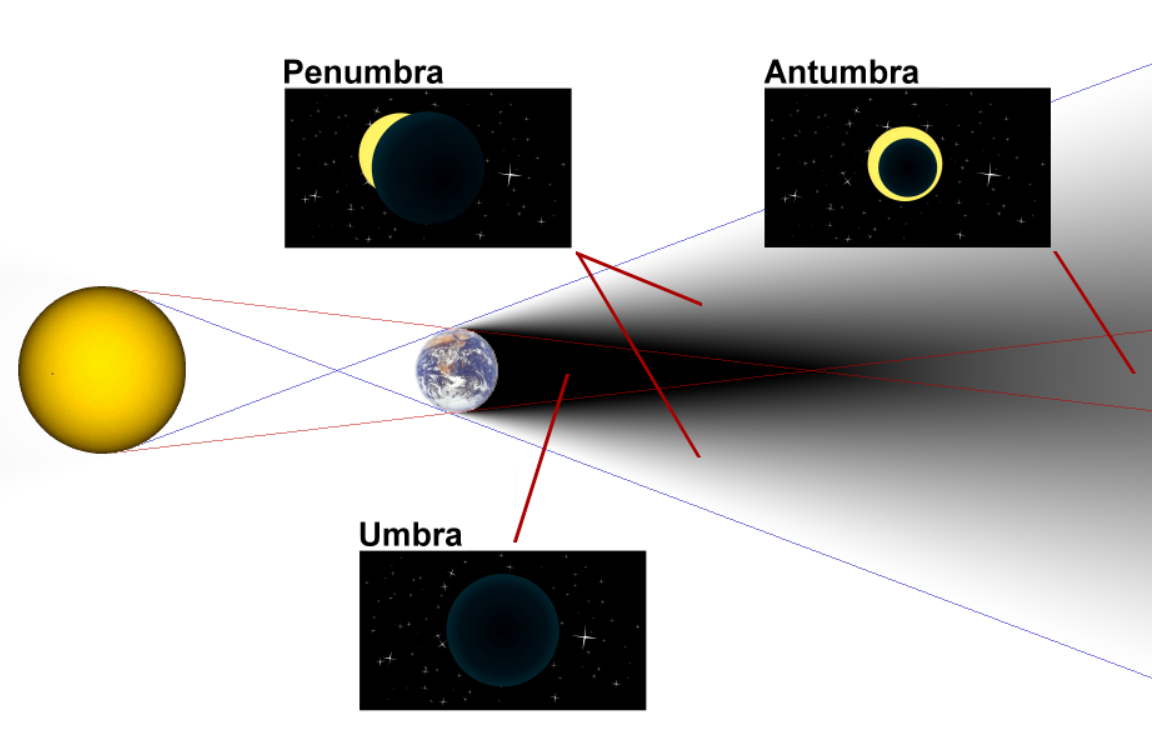

The following equation is based on the geometric relationship between the primary and secondary bodies in an orbital system. By considering the shadow width at the orbital distance a and comparing it to the total orbital circumference, we approximate the fraction of the orbit in which the secondary body experiences some level of eclipse. The result,:

$$
P_{eclipse} = \frac{R_{primary} + R_{secondary}}{a}
$$

suggests that the probability of an eclipse depends on the radii of both the primary and secondary bodies, as well as their separation. Specifically, the probability increases for larger primary bodies (which cast wider shadows), larger secondary bodies (which are more likely to intersect a shadow), and smaller orbital distances (where the shadow covers a greater fraction of the orbit). However, this expression does not distinguish between total, partial, or annular eclipses, as those depend on the detailed geometry of the umbra, penumbra, and antumbra regions.


In [86]:
#Let's use the binary from the above cell
probEclipse = (R1+R2)/a

print("Percent chance of seeing the eclipse of the binary system discussed in the previous cell: " +str(probEclipse*100) + "%")

Percent chance of seeing the eclipse of the binary system discussed in the previous cell: 10.132142944037547%


# Part 5 - Comparing the Eclipsing Binaries to the Overall Population

## 5.1 - Comparing Histograms Visually

Now that we have our eclipsing population, we can look at how it compares to the overall population, and see how it looks from a statistical standpoint. To start with, let's overlay the graphs of primary mass, secondary mass, period, and eccentricity:

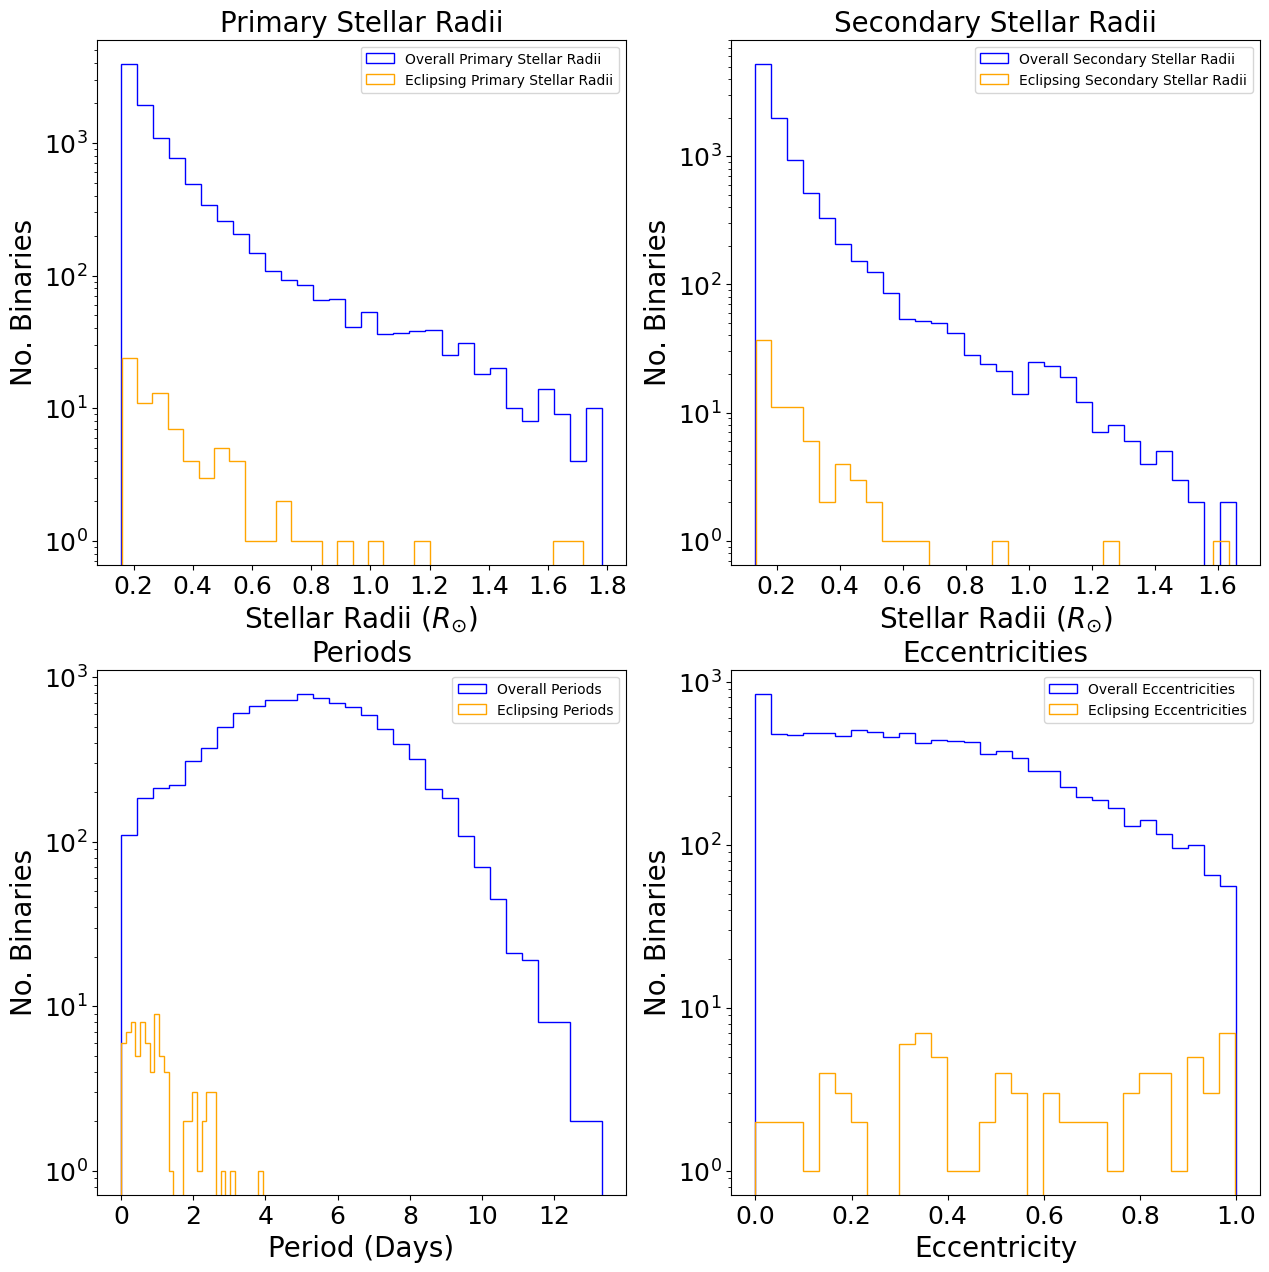

In [87]:
#Create our figure, define lists for storing graph data:
eclipseFig = plt.figure(figsize=(15,15))
eclipsePrimaryRadii = []
eclipseSecondaryRadii = []
eclipseSemiMajorAxes = []
eclipseEccentricities = []
eclipsePeriods = []

#Loop over eclipsing binaries
for i in range(len(eclipsingBinaries)):
  eclipseIndex = eclipsingBinaries[i]
  R1, R2, a, e, I, Omega, omega, theta = binaryFormation(eclipseIndex) #Get the positional values from our binary formation function, for convenience
  period = sampledPeriods[eclipseIndex] #Also grab the periods from the initial distribution

  #Store the values in lists
  eclipsePrimaryRadii.append(R1/rSun_m) #Converted back into solar radii
  eclipseSecondaryRadii.append(R2/rSun_m) #Converted back into solar radii
  eclipsePeriods.append(period) #In seconds
  eclipseEccentricities.append(e) #No units


#Create a histogram comparing the PRIMARY RADII of eclipsing vs. regular binaries
ax1 = eclipseFig.add_subplot(221)
ax1.hist(primaryRadiusArray,bins=30, histtype = "step", color = 'blue', label='Overall Primary Stellar Radii')
ax1.hist(eclipsePrimaryRadii,bins=30,histtype = "step", color = 'orange', label='Eclipsing Primary Stellar Radii')
plt.yscale('log') #Log scale, so the eclipse values are actually visible
ax1.set_title("Primary Stellar Radii", fontsize=20)
ax1.set_xlabel('Stellar Radii ($R_{\odot}$)', fontsize=20)
ax1.set_ylabel('No. Binaries',fontsize=20)
ax1.legend(["All Binaries", "Eclipsing Binaries"])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()

#Create a histogram comparing the SECONDARY RADII of eclipsing vs. regular binaries
ax2 = eclipseFig.add_subplot(222)
ax2.hist(secondaryRadiusArray,bins=30, histtype = "step", color = 'blue', label='Overall Secondary Stellar Radii')
ax2.hist(eclipseSecondaryRadii,bins=30,histtype = "step", color = 'orange', label='Eclipsing Secondary Stellar Radii')
plt.yscale('log') #Log scale, so the eclipse values are actually visible
ax2.set_title("Secondary Stellar Radii", fontsize=20)
ax2.set_xlabel('Stellar Radii ($R_{\odot}$)', fontsize=20)
ax2.set_ylabel('No. Binaries',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()

#Create a histogram comparing the PERIODS of eclipsing vs. regular binaries
ax2 = eclipseFig.add_subplot(223)
ax2.hist(sampledPeriods,bins=30, histtype = "step", color = 'blue', label='Overall Periods')
ax2.hist(eclipsePeriods,bins=30,histtype = "step", color = 'orange', label='Eclipsing Periods')
plt.yscale('log') #Log scale, so the eclipse values are actually visible
ax2.set_title("Periods", fontsize=20)
ax2.set_xlabel('Period (Days)', fontsize=20)
ax2.set_ylabel('No. Binaries',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()

#Create a histogram comparing the ECCENTRICITIES of eclipsing vs. regular binaries
ax2 = eclipseFig.add_subplot(224)
ax2.hist(GED_noisy,bins=30, histtype = "step", color = 'blue', label='Overall Eccentricities')
ax2.hist(eclipseEccentricities,bins=30,histtype = "step", color = 'orange', label='Eclipsing Eccentricities')
plt.yscale('log') #Log scale, so the eclipse values are actually visible
ax2.set_title("Eccentricities", fontsize=20)
ax2.set_xlabel('Eccentricity', fontsize=20)
ax2.set_ylabel('No. Binaries',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()

plt.show()

At a glance, the radii look fairly similar to the overall (it's a bit tricky to compare them with the log scale), but the eclipsing periods are much shorter on average. Eccentricity is harder to tell.

## 5.2 - Using Z Test to Compare the Eclipsing Binaries to the Overall Population

To get a better comparison of the eclipsing and non-eclipsing populations, we can apply a Z test. This will compare the sample and population means (in this case, the eclipsing population and the overall population, respectively) and work out the probability of the eclipsing population looking the way it does if it's a simple random sample of the population, with no underlying differences. If we get a low p-score, we will have reason to think that this is not the case, and that binaries with certain properties eclipse more often than others.

In [88]:
#We'll be treating the whole population of binaries as our population, and the eclipsing binaries as our sample.

NoEclipsing = len(eclipsingBinaries) #Number of eclipsing binaries in our population - this will be our sample size

#We find the standard error of the four distributions
primaryRadiiSE = np.std(primaryRadiusArray)/np.sqrt(NoEclipsing)
secondaryRadiiSE = np.std(secondaryRadiusArray)/np.sqrt(NoEclipsing)
periodSE = np.std(sampledPeriods)/np.sqrt(NoEclipsing)
eccentricitySE = np.std(GED_noisy)/np.sqrt(NoEclipsing)

#Now we find the Z value, which will compare the population mean to the sample mean
primaryRadiiZ = (np.mean(eclipsePrimaryRadii) - np.mean(primaryRadiusArray))/primaryRadiiSE
secondaryRadiiZ = (np.mean(eclipseSecondaryRadii) - np.mean(primaryRadiusArray))/primaryRadiiSE
periodZ = (np.mean(eclipsePeriods) - np.mean(primaryRadiusArray))/primaryRadiiSE
eccentricityZ = (np.mean(eclipseEccentricities) - np.mean(primaryRadiusArray))/primaryRadiiSE

#We can now use the Z value to get a p score. In this case, we'll be using the null hypothesis that the eclipsing binaries are just a random set
#drawn from the overall population, with no underlying differences
#We'll use norm to convert the Z value to a cdf

def CalculatePScore(zScore):
  p_lessthan_Z = norm.cdf(-1*np.abs(zScore),0,1)
  p_greaterthan_Z = 1-norm.cdf(np.abs(zScore),0,1)
  p_value = p_lessthan_Z + p_greaterthan_Z
  return p_value

primaryRadiiP = CalculatePScore(primaryRadiiZ)
secondaryRadiiP = CalculatePScore(secondaryRadiiZ)
periodP = CalculatePScore(periodZ)
eccentricityP = CalculatePScore(eccentricityZ)

print("For the primary radii, we have a p-value of " + str(primaryRadiiP) + "; for the secondary radii, we have a p-value of " + str(secondaryRadiiP) +
      ";\n for the period, we have a p-value of " + str(periodP) +  "; and for the eccentricity, we have a p-value of " + str(eccentricityP) + ".")


For the primary radii, we have a p-value of 0.02480787314250872; for the secondary radii, we have a p-value of 0.08629184275434548;
 for the period, we have a p-value of 3.981641248628713e-167; and for the eccentricity, we have a p-value of 1.3290266051902215e-17.


We can see that the period distribution has an extremely low p-score, meaning that the eclipsing population is almost certainly not representative of the overall in this regard. Likewise, the eccentricity distribution also has a lower p-score. Our data has been returning a range of anywhere from 0.9 to 1E-20 depending on the binary systems sampled which, while greater than the period p-value, is still lower than the radii p-scores on average. This combined with the fact that our values for eccentricities are derived from the period, allows us to say with relatively strong statistical significance that our eccentricities are not representative of the overall population either. Primary and secondary radii have relatively high p-scores, suggesting that the eclipsing binaries do not significantly differ from the overall population in stellar radii.

# Part 6 - References

* Halbwachs, J.-L., et al. (2003)
* Raghavan, D., et al. (2010)
* Astrophysics Laboratory Course Material: 3d_binary_geometry.ipynb
* Initial mass function. Retrieved from https://en.wikipedia.org/wiki/Initial_mass_function
* Bonus Lecture 1: Binary Stars. Retrieved from https://www.dropbox.com/scl/fi/3r7jph2yseroq17pkfjz9/Bonus_Lecture_1_Binary_Stars.MP4?rlkey=vazz1y7ft0meh2j1g2xvxe20z&dl=0
* Bonus Lecture 2: Orbital Elements. Retrieved from https://www.dropbox.com/scl/fi/1bacr1dkej2dcqh77rov6/Bonus_Lecture_2_Orbital_Elements.MP4?rlkey=jwcikusxevcfofdpt04xm543y&dl=0

